<a href="https://colab.research.google.com/github/dia-ks/Karate_club_assignment/blob/main/IMS24088_DSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computed 3 snapshot(s) (including initial full graph).


,"(0, degree_centrality)","(0, betweenness_centrality)","(0, closeness_centrality)","(0, clustering)","(1, degree_centrality)","(1, betweenness_centrality)","(1, closeness_centrality)","(1, clustering)","(2, degree_centrality)","(2, betweenness_centrality)",...,"(31, closeness_centrality)","(31, clustering)","(32, degree_centrality)","(32, betweenness_centrality)","(32, closeness_centrality)","(32, clustering)","(33, degree_centrality)","(33, betweenness_centrality)","(33, closeness_centrality)","(33, clustering)"
iter_0,0.484848,0.437635,0.568966,0.150000,0.272727,0.053937,0.485294,0.333333,0.303030,0.143657,...,0.540984,0.2,0.363636,0.145247,0.515625,0.196970,0.515152,0.304075,0.550000,0.110294
iter_1,0.933333,0.689683,0.937500,0.186813,0.533333,0.073810,0.652174,0.428571,0.333333,0.002381,...,0.586207,0.3,0.647059,0.201225,0.739130,0.218182,0.882353,0.570343,0.894737,0.142857
iter_2,0.833333,0.377778,0.857143,0.400000,0.875000,0.654762,0.888889,0.238095,0.500000,0.011905,...,0.586207,0.3,0.647059,0.201225,0.739130,0.218182,0.882353,0.570343,0.894737,0.142857



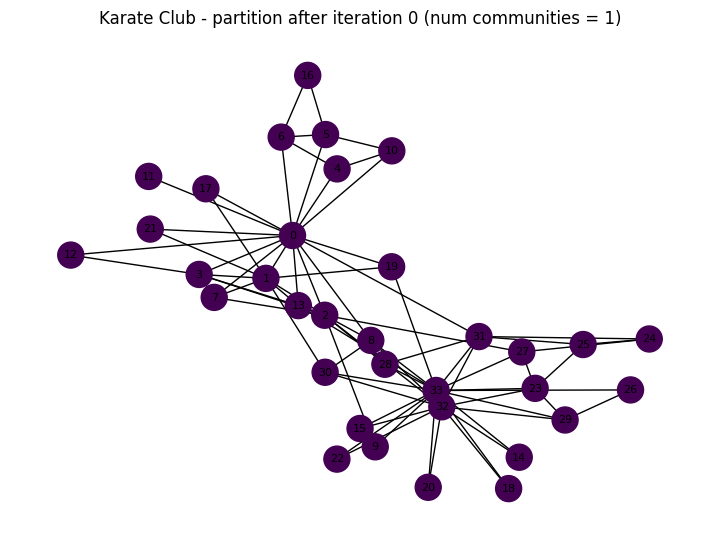
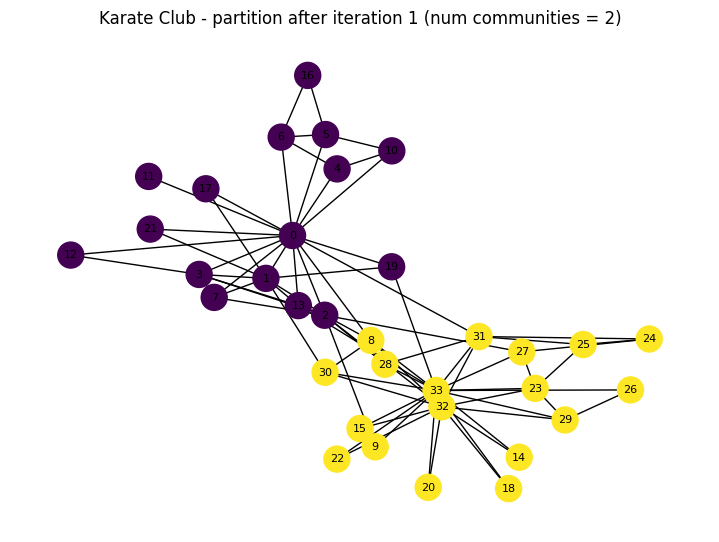
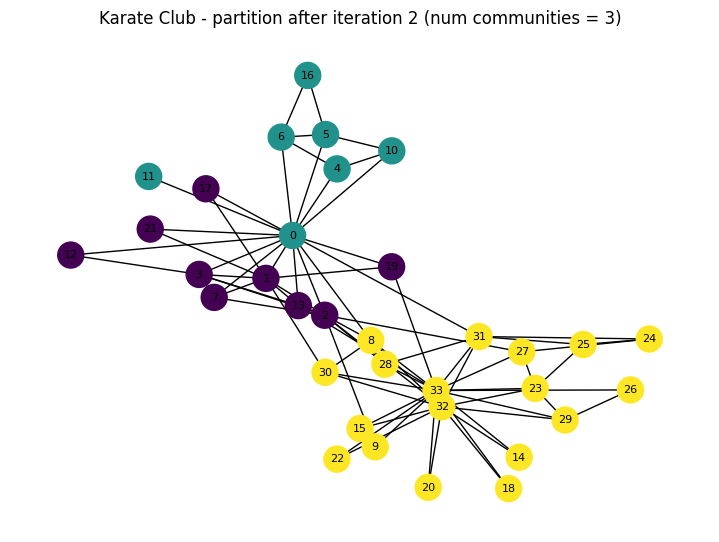


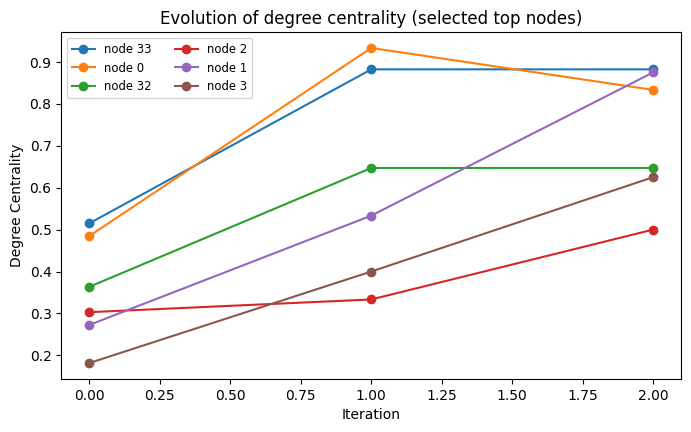
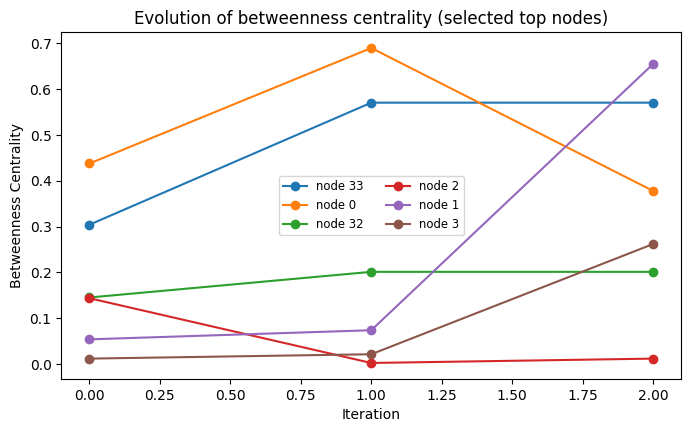
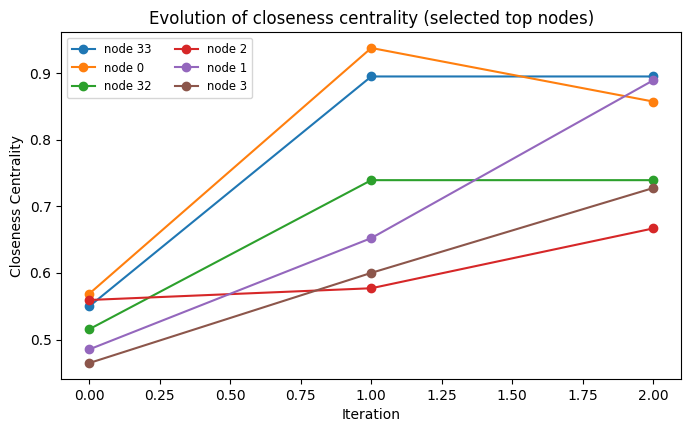
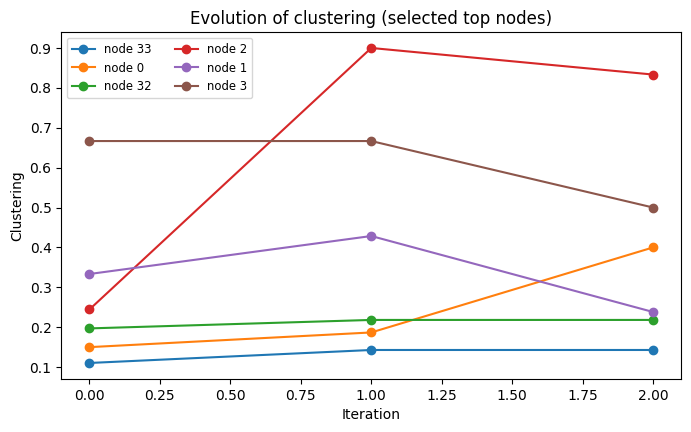

CSV saved to /mnt/data/karate_metrics_by_iteration.csv

Discussion (short):
- The spectral modularity partitioner produced progressive splits; starting from the whole graph it created up to 3 communities by iteration 2.
- Node-level metrics were computed inside each node's community (i.e., on the induced subgraph) so metrics evolve because community boundaries change.
- Degree centrality inside a small induced community tends to be higher for nodes that retain many internal edges; core nodes (like the original high-degree nodes shown above) often preserve high degree centrality across iterations.
- Betweenness centrality is sensitive to how a node connects otherwise-distant groups: nodes that sit on bridge-like positions inside a community see betweenness increase when their community is split in ways that route shortest paths through them; conversely it drops when they end up in a small, dense community with fewer between-community paths.
- Closeness centrality fluctuates as community

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import isclose
import io, base64, os
from IPython.display import HTML, display

def modularity_matrix_subgraph(G, nodes):
    A = nx.to_numpy_array(G, nodelist=nodes)
    k = A.sum(axis=1)
    m = A.sum() / 2.0
    if isclose(m, 0.0):
        B = A - np.outer(k, k) * 0.0
    else:
        B = A - np.outer(k, k) / (2.0 * m)
    return B, k, m

def leading_eigenpair(B):

    vals, vecs = np.linalg.eig(B)
    idx = np.argmax(vals.real)
    return vals.real[idx], vecs[:, idx].real

def split_community(G, nodes):
    B, k, m = modularity_matrix_subgraph(G, nodes)
    lam, u = leading_eigenpair(B)
    if lam <= 1e-8:
        return None, None, lam
    signs = np.sign(u)
    signs[signs == 0] = 1.0
    group1 = [nodes[i] for i in range(len(nodes)) if signs[i] > 0]
    group2 = [nodes[i] for i in range(len(nodes)) if signs[i] < 0]
    if len(group1) == 0 or len(group2) == 0:
        return None, None, lam
    return group1, group2, lam

def recursive_spectral_partition(G, max_splits=5):
    communities = [list(G.nodes())]
    snapshots = [communities.copy()]
    lam_history = []
    for it in range(max_splits):
        best_idx = None
        best_lam = -np.inf
        best_split = None
        # find community with largest positive leading eigenvalue to split
        for i, comm in enumerate(communities):
            if len(comm) < 2:
                continue
            _, _, lam = modularity_matrix_subgraph(G, comm)
            B,_,_ = modularity_matrix_subgraph(G, comm)
            lam_c, _ = leading_eigenpair(B)
            if lam_c > best_lam:
                best_lam = lam_c
                best_idx = i
        if best_idx is None or best_lam <= 1e-8:
            lam_history.append(best_lam)
            break
        g1, g2, lam_used = split_community(G, communities[best_idx])
        if g1 is None:
            lam_history.append(lam_used)
            break
        # replace that community with the two new communities
        new_communities = communities[:best_idx] + [g1, g2] + communities[best_idx+1:]
        communities = new_communities
        snapshots.append(communities.copy())
        lam_history.append(lam_used)
    return snapshots, lam_history

# Run recursive spectral partitioning for 2 splits (iterations)
G = nx.karate_club_graph()
max_splits = 2
snapshots, lam_history = recursive_spectral_partition(G, max_splits=max_splits)

# For visualization and metric computation, we'll include the initial partition (0) and each split result
n_iters = len(snapshots)
print(f"Computed {n_iters} snapshot(s) (including initial full graph).")

# Create a mapping of community id for each node at each iteration
iter_assignments = []
for it, comms in enumerate(snapshots):
    assign = {}
    for cid, comm in enumerate(comms):
        for node in comm:
            assign[node] = cid
    iter_assignments.append(assign)

# Compute node metrics per iteration on induced subgraphs of each community
metrics = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'clustering']
data = {it: {n: {} for n in G.nodes()} for it in range(n_iters)}

for it in range(n_iters):
    comms = snapshots[it]
    for cid, comm in enumerate(comms):
        sub = G.subgraph(comm)
        deg = nx.degree_centrality(sub)
        bet = nx.betweenness_centrality(sub, normalized=True)
        clo = nx.closeness_centrality(sub)
        clust = nx.clustering(sub)
        for node in comm:
            data[it][node]['degree_centrality'] = deg.get(node, 0.0)
            data[it][node]['betweenness_centrality'] = bet.get(node, 0.0)
            data[it][node]['closeness_centrality'] = clo.get(node, 0.0)
            data[it][node]['clustering'] = clust.get(node, 0.0)

# Convert data to DataFrames for display: multiindex (node, metric) columns, rows=iteration
rows = []
for it in range(n_iters):
    row = {}
    for node in sorted(G.nodes()):
        for metric in metrics:
            row[(node, metric)] = data[it][node][metric]
    rows.append(row)

df = pd.DataFrame(rows, index=[f"iter_{i}" for i in range(n_iters)])
# reorder columns to (node, metric) sorted by node then metric
df = df.reindex(sorted(df.columns, key=lambda x: (x[0], metrics.index(x[1]))), axis=1)

# Display the DataFrame to user in interactive table form
display(df)

# --- Visualize the graph after each split ---
pos = nx.spring_layout(G, seed=42)  # keep positions fixed for comparability

image_files = []
for it in range(n_iters):
    plt.figure(figsize=(7,5))
    comms = snapshots[it]
    assign = iter_assignments[it]
    node_color = [assign[n] for n in G.nodes()]
    nx.draw(G, pos=pos, with_labels=True, node_color=node_color, cmap=None, node_size=350, font_size=8)
    plt.title(f"Karate Club - partition after iteration {it} (num communities = {len(comms)})")
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('ascii')
    image_files.append(img_b64)
    plt.close()

# Display the saved images inline (as outputs)
html_frag = "<h3>Graph partitions by iteration</h3>"
for it, b64 in enumerate(image_files):
    html_frag += f"<div><h4>Iteration {it} - {len(snapshots[it])} community(ies)</h4>"
    html_frag += f'<img src="data:image/png;base64,{b64}" style="max-width:700px;border:1px solid #ccc;margin-bottom:12px;"></div>'
display(HTML(html_frag))

# --- Plot metric evolution across iterations for a subset of nodes ---
deg_orig = dict(G.degree())
top_nodes = sorted(deg_orig, key=lambda x: deg_orig[x], reverse=True)[:6]

# Prepare metric time series
iters = list(range(n_iters))
plt.rcParams.update({'figure.max_open_warning': 0})

plots = []
for metric in metrics:
    plt.figure(figsize=(8,4.5))
    for node in top_nodes:
        vals = [data[it][node][metric] for it in iters]
        plt.plot(iters, vals, marker='o', label=f"node {node}")
    plt.xlabel("Iteration")
    plt.ylabel(metric.replace('_',' ').title())
    plt.title(f"Evolution of {metric.replace('_',' ')} (selected top nodes)")
    plt.legend(loc='best', fontsize='small', ncol=2)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('ascii')
    plots.append((metric, img_b64))
    plt.close()

html_plots = "<h3>Metric evolution (top nodes by degree)</h3>"
for metric, b64 in plots:
    html_plots += f"<div><h4>{metric.replace('_',' ').title()}</h4>"
    html_plots += f'<img src="data:image/png;base64,{b64}" style="max-width:800px;border:1px solid #ccc;margin-bottom:12px;"></div>'
display(HTML(html_plots))

# Save a CSV summary for user's download
out_dir = "/mnt/data"
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "karate_metrics_by_iteration.csv")
df.to_csv(csv_path)
print(f"CSV saved to {csv_path}")

# Compose a short discussion to return with the results
discussion = """
Discussion (short):
- The spectral modularity partitioner produced progressive splits; starting from the whole graph it created up to {n_comms} communities by iteration {last_iter}.
- Node-level metrics were computed inside each node's community (i.e., on the induced subgraph) so metrics evolve because community boundaries change.
- Degree centrality inside a small induced community tends to be higher for nodes that retain many internal edges; core nodes (like the original high-degree nodes shown above) often preserve high degree centrality across iterations.
- Betweenness centrality is sensitive to how a node connects otherwise-distant groups: nodes that sit on bridge-like positions inside a community see betweenness increase when their community is split in ways that route shortest paths through them; conversely it drops when they end up in a small, dense community with fewer between-community paths.
- Closeness centrality fluctuates as community size shrinks; nodes in small tight clusters often get higher closeness scores inside that induced subgraph (short average shortest path within the small community).
- Clustering coefficient is local and depends only on triangles within the induced community; splitting that cuts triangles reduces clustering for nodes that lose triangle partners.
- Overall: a small subset of nodes (the high-degree nodes chosen above) remain relatively central across iterations — they maintain higher degree and often higher closeness — while bridging nodes show the largest relative changes in betweenness as splits rearrange shortest-path structure.
""".format(n_comms=len(snapshots[-1]), last_iter=n_iters-1)

print(discussion)
